# Mini Project 2

## 2.1.1

### Study and implement the Particle-Swarm Optimization algorithm.

The group decided to implement the algorithm using objects, as it is more readable and debuggable than a purely mathematical approach.

The group created an object representing each particle in a swarm:

In [1]:
# Import dependencies.
import random
import sympy as sp

In [2]:
class Particle:
    def __init__(
        self,
        func,
        x0: list,
        aCognitive: float = 2,
        aSocial: float = 2,
        inertia: float = 0.5,
        dataset = None,
    ):
        # DEBUG
        self.coordinatesX = []
        self.coordinatesY = []
        self.coordinatesZ = []

        # The mathematical function to calculate the value for a given configuration.
        self.func = func
        
        # Dataset from which the fitness function compares func to
        self.dataset = dataset

        # The number of parameters to be optimized.
        self.dimension: int = len(x0)

        # The coefficients that define particle dynamics.
        self.aCognitive: float = aCognitive
        self.aSocial: float = aSocial

        # Generate random initial velocities from -1 to 1.
        v0 = []
        for i in range(self.dimension):
            v0.append(random.uniform(-1, 1))

        # The current state of the system.
        self.x: list = x0
        self.v: list = v0
        self.inertia: float = inertia

        # The personal best.
        if self.dataset is not None:
            self.bestValue: float = self.func(*self.x, self.dataset)
        else:
            self.bestValue: float = self.func(*self.x)
        self.bestPosition: list = self.x

    def update(self, globalBest: list):
        """Update the particle's state during each iteration.

        Args:

        globalBest (number list): Describes the configuration for the previously known global best.
        """
        try:
            vNext: list = []
            xNext: list = []

            for i in range(self.dimension):
                r1: float = random.uniform(0, 1)
                r2: float = random.uniform(0, 1)

                vNext.append(
                    self.inertia * self.v[i]
                    + self.aCognitive * (self.bestPosition[i] - self.x[i]) * r1
                    + self.aSocial * (globalBest[i] - self.x[i]) * r2
                )
                xNext.append(self.x[i] + vNext[i])

            self.x: list = xNext
            self.v: list = vNext

            if self.dataset is not None:
                currentFitness: float = self.func(*self.x, self.dataset)
            else:
                currentFitness: float = self.func(*self.x)

            if currentFitness <= self.bestValue:
                self.bestValue: float = currentFitness
                self.bestPosition: list = self.x

            # DEBUG
            self.coordinatesX.append(self.bestPosition[0])
            self.coordinatesY.append(self.bestPosition[1])
            self.coordinatesZ.append(self.bestValue)

        except IndexError:
            print(
                "WARN: Dimensions of global best must match amount of parameters to be optimized."
            )
            raise IndexError

For the parameters of the particle, we use the recommended values
$$\begin{align}
a_{social} &= 2\\
a_{cognitive} &= 2
\end{align}$$
from the paper.

For the inertia $\omega$, the recommended value of 1 does not perform well, so we use a smaller value of 0.5, which seems to perform significantly better.

In addition to the particle, we implemented a swarm object to control these particles:

In [3]:
class ParticleSwarm:
    def __init__(
        self,
        func,
        coordsMin: list,
        coordsMax: list,
        populationSize: int = 50,
        initStrategy: str = "random",
        dataset = None,
    ):
        # DEBUG
        self.coordinatesX = []
        self.coordinatesY = []
        self.coordinatesZ = []
        try:
            # Define member variables.
            #x, y = sp.symbols("x y")
            #self.func = sp.lambdify((x, y), func)
            self.func = func
            self.dimensions: int = len(coordsMin)
            self.coordsMin: list = coordsMin
            self.coordsMax: list = coordsMax
            self.populationSize: int = populationSize
            self.particles: list = []
            self.dataset = dataset

            # Particle instances of the particle swarm.
            for i in range(populationSize):
                x0 = [
                    random.uniform(self.coordsMin[j], self.coordsMax[j])
                    for j in range(self.dimensions)
                ]

                self.particles.append(Particle(self.func, x0, dataset = self.dataset ))

                if i == 0 or self.particles[i].bestValue < self.bestValue:
                    self.bestPosition = self.particles[i].bestPosition
                    self.bestValue = self.particles[i].bestValue

        except IndexError:
            print(
                "WARN: Dimensions of boundary minimum and boundary maximum must be the same."
            )
            raise IndexError

    def run(self, hysteresis: float = 1e-6, iterations: int = 25 , print_best = False):
        delta = hysteresis + 1
        iteration = 0

        while iteration < iterations:
            bestValuePrevious = self.bestValue
            # Update the particle position and the particle velocities.
            for particle in self.particles:
                particle.update(self.bestPosition)

                # Check if the particle fitness is a new global best.
                if particle.bestValue <= self.bestValue:
                    self.bestValue = particle.bestValue
                    self.bestPosition = particle.bestPosition

            # Calculate the change in global best.
            try:
                delta = bestValuePrevious - self.bestValue
            except TypeError:
                delta = bestValuePrevious - self.bestValue[0]

            # Check if error is within hysteresis.
            if delta <= hysteresis:
                iteration = iteration + 1
            else:
                iteration = 0
                # DEBUG
                self.coordinatesX.append(self.bestPosition[0])
                self.coordinatesY.append(self.bestPosition[1])
                self.coordinatesZ.append(self.bestValue)
                if print_best == True:
                    print(self.bestValue)

## 2.1.2
### Test, demonstrate and visualize your implementation on the Ackley function

To use the Ackley function, we first define it in Python as a Sympy function.

In [4]:
def ackley():
    x, y = sp.symbols("x y")
    f = sp.Function("f")
    f = (
        sp.exp(1)
        + 20
        - 20 * sp.exp(-0.2 * sp.sqrt(0.5 * (x * x + y * y)))
        - sp.exp(0.5 * (sp.cos(2 * sp.pi * x) + sp.cos(2 * sp.pi * y))),
    )
    
    return f, x, y

We also create a lambdified version of the function for performance purposes.

In [5]:
f, x, y = ackley()
ackley_lambdified = sp.lambdify([x,y], f)

def ackley_function(x,y):
    # We use the zero index because the function returns a tuple.
    return  ackley_lambdified(x,y)[0]

We then plot the function.

In [6]:
# Import dependencies.
import numpy as np
import matplotlib as mpl
import ipywidgets as widgets

# Configure plotting.
sp.interactive.init_printing(use_unicode=False, wrap_line=False, no_global=True)
%matplotlib notebook

<IPython.core.display.Javascript object>


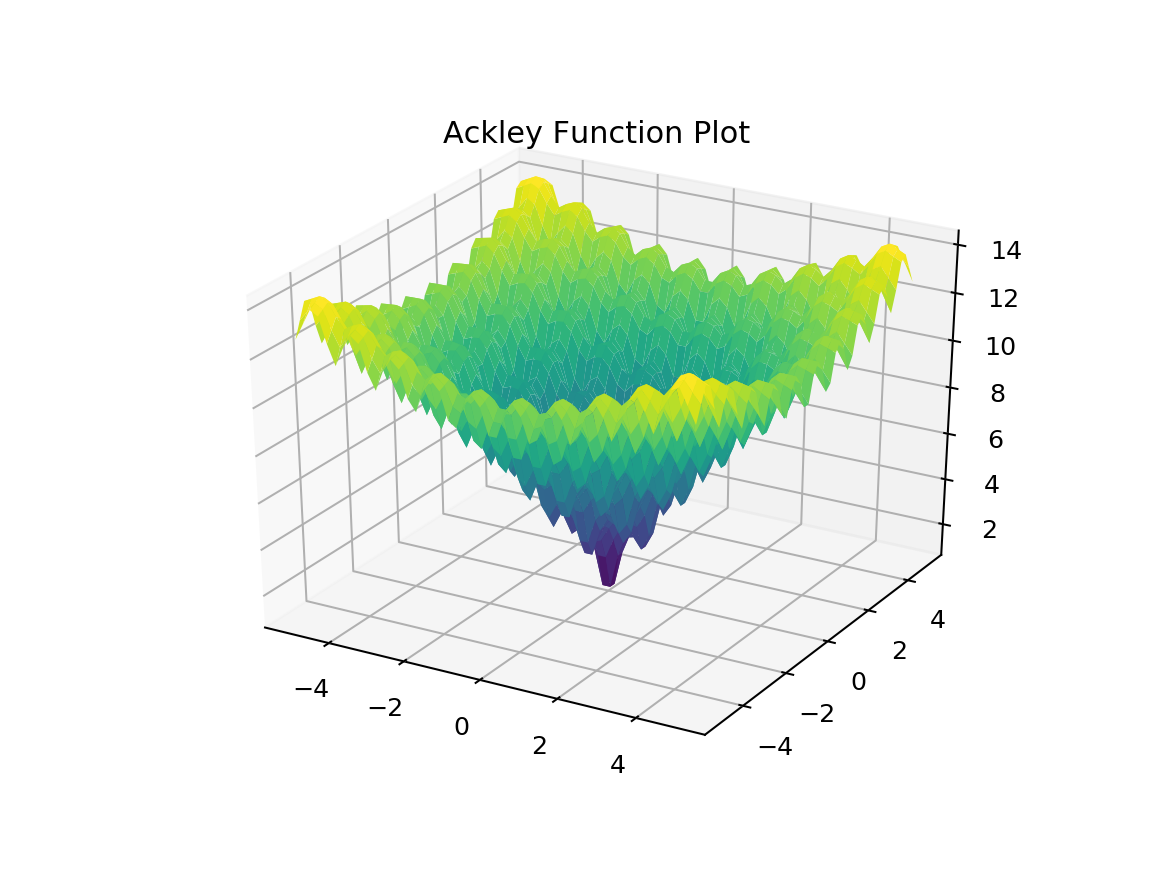

In [7]:
# Define the function.
f, x, y = ackley();

size = 5

# Define a plot range and plot the function with sympy: 
yMin, yMax, xMin, xMax = -size, size, -size, size
plot = sp.plotting.plot3d(f, (x, xMin, xMax), (y, yMin, yMax), title = 'Ackley Function Plot');


Since the Ackley function looks good, we now demonstrate our PSO algorithm.

In [8]:
swarm = ParticleSwarm(ackley_function, (xMin, yMin), (xMax, yMax))

swarm.run()

<IPython.core.display.Javascript object>


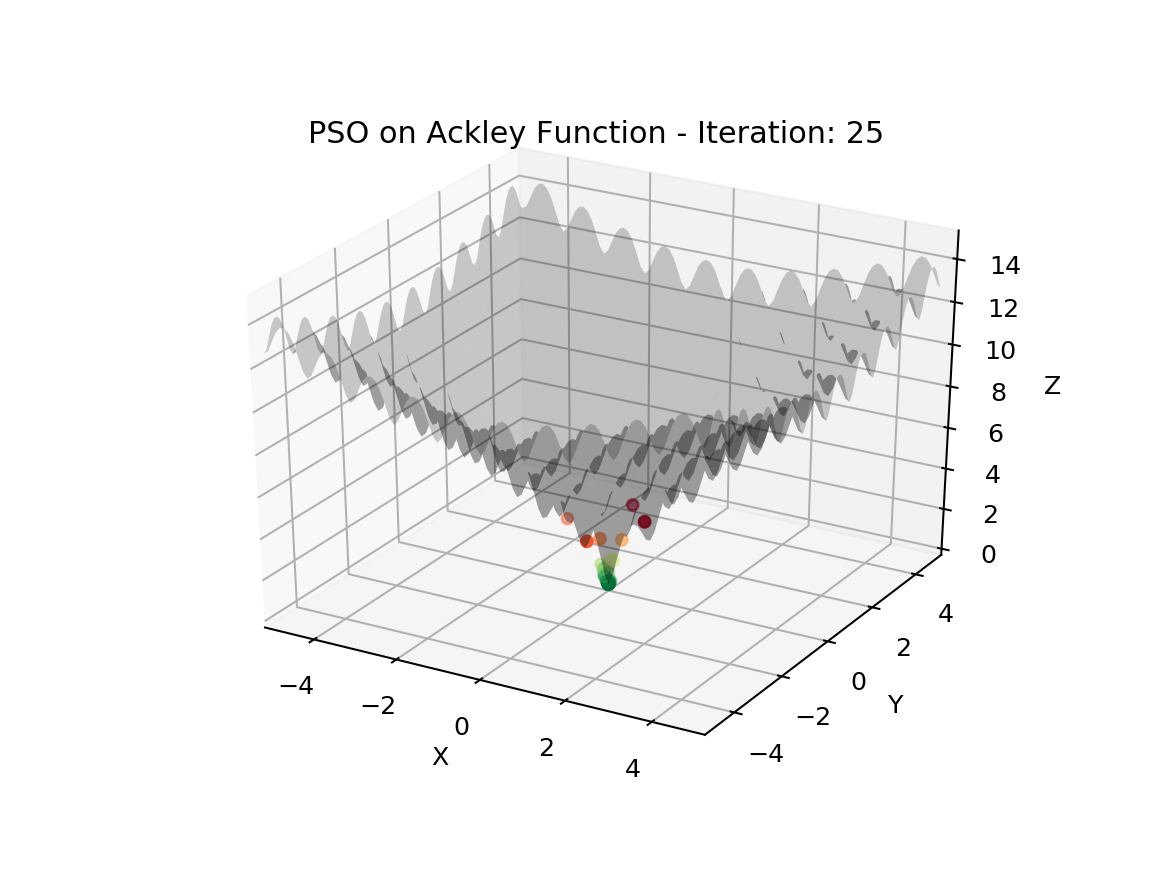

A Jupyter Widget

In [11]:
fig = mpl.pyplot.figure(2)
ax = fig.add_subplot(111, projection='3d')

def plot_func(iteration):
    xp = []
    yp = []
    zp = []
    for particle in swarm.particles:
        xp.append(particle.coordinatesX[iteration])
        yp.append(particle.coordinatesY[iteration])
        zp.append(particle.coordinatesZ[iteration])
        
    span = 5
    stepSize = 0.1
        
    xa = np.arange(-span, span+stepSize, stepSize)
    ya = np.arange(-span, span+stepSize, stepSize)
    xa, ya = np.meshgrid(xa, ya)
    za = np.zeros(xa.shape)
    
    it = np.nditer(za, flags=['multi_index'], op_flags=['readwrite']) 
    while not it.finished:
        i, j = it.multi_index
        za[i, j] = swarm.func(xa[i, j], ya[i, j])
        it.iternext()
    
    ax.cla()
    
    ax.set_xbound(-size, size)
    ax.set_ybound(-size, size)
    ax.set_zbound(0, size*3)
    ax.set_autoscale_on(False)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"PSO on Ackley Function - Iteration: {iteration}")
    
    surf = ax.plot_surface(xa, ya, za, color=(0, 0, 0, 0.2), rcount=span*2+1, ccount=span*2+1)
    scatter = ax.scatter(xp, yp, zp, c=zp, cmap="RdYlGn_r")
    
    
widgets.interact(plot_func, iteration=widgets.IntSlider(value=0, min=0, max=len(swarm.particles[0].coordinatesZ)-1, step=1), continuous_update=False);

<IPython.core.display.Javascript object>


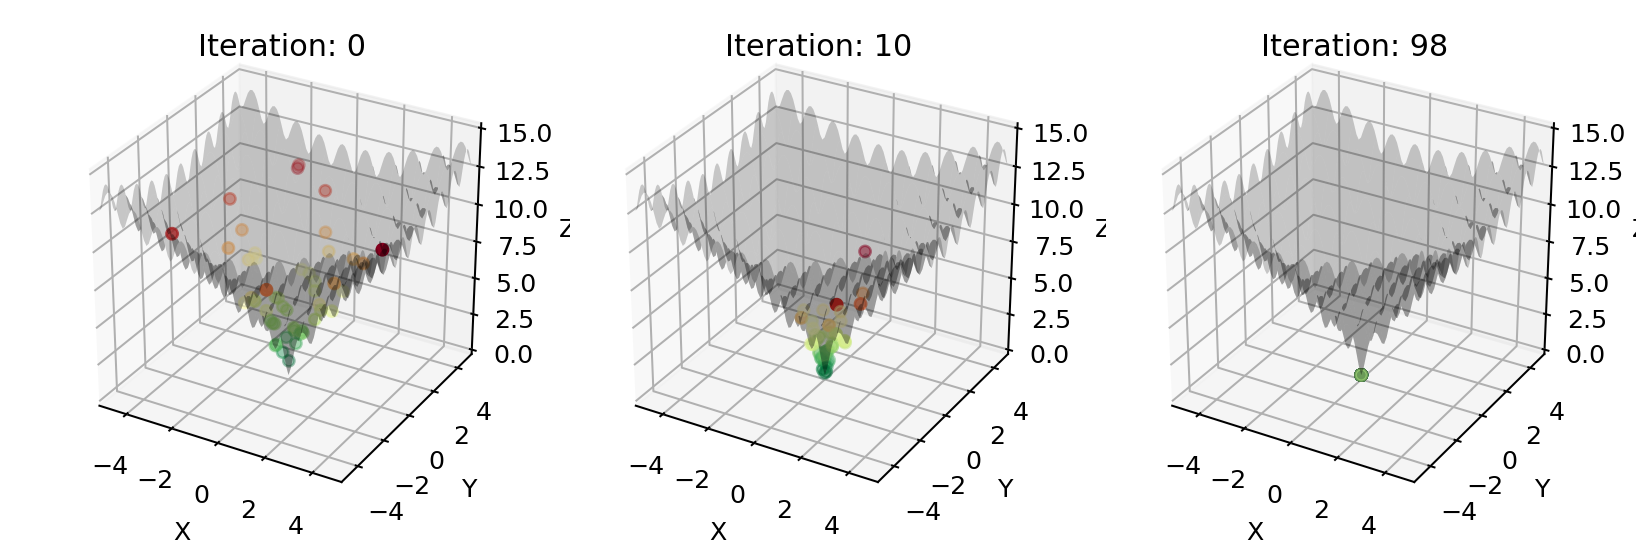

In [12]:
fig3 = mpl.pyplot.figure(3, figsize=(9, 9/3))
ax1 = fig3.add_subplot(1, 3, 1, projection='3d')
ax2 = fig3.add_subplot(1, 3, 2, projection='3d')
ax3 = fig3.add_subplot(1, 3, 3, projection='3d')

def subplot_func(axes, iteration):
    xp = []
    yp = []
    zp = []
    for particle in swarm.particles:
        xp.append(particle.coordinatesX[iteration])
        yp.append(particle.coordinatesY[iteration])
        zp.append(particle.coordinatesZ[iteration])
        
    span = 5
    stepSize = 0.1
        
    xa = np.arange(-span, span+stepSize, stepSize)
    ya = np.arange(-span, span+stepSize, stepSize)
    xa, ya = np.meshgrid(xa, ya)
    za = np.zeros(xa.shape)
    
    it = np.nditer(za, flags=['multi_index'], op_flags=['readwrite']) 
    while not it.finished:
        i, j = it.multi_index
        za[i, j] = swarm.func(xa[i, j], ya[i, j])
        it.iternext()
    
    axes.cla()
    
    axes.set_xbound(-size, size)
    axes.set_ybound(-size, size)
    axes.set_zbound(0, size*3)
    axes.set_autoscale_on(False)
    axes.set_xlabel('X')
    axes.set_ylabel('Y')
    axes.set_zlabel('Z')
    axes.set_title(f"Iteration: {iteration}")
    
    surf = axes.plot_surface(xa, ya, za, color=(0, 0, 0, 0.2), rcount=span*2+1, ccount=span*2+1)
    scatter = axes.scatter(xp, yp, zp, c=zp, cmap="RdYlGn_r")
    
subplot_func(ax1, 0)
subplot_func(ax2, 10)
subplot_func(ax3, len(swarm.particles[0].coordinatesZ) - 1)

mpl.pyplot.tight_layout()

As seen above, the algorithm converges nicely to the minimum of the Ackley function.

In [13]:
print(f"Swarm best value: {swarm.bestValue:.5}\nSwarm best position: ({swarm.bestPosition[0]:.5}, {swarm.bestPosition[1]:.5})")

Swarm best value: 6.0276e-09
Swarm best position: (-1.3855e-09, 1.6192e-09)


The final values are very close to the correct values of 0 and a position of (0,0).

## 2.2.1
### Load and visualize the two-dimensional data set "experimental_data_xy.dat"

In [14]:
# Sympy imports for calculation and nice display: 
from sympy.matrices import *
from sympy.plotting import plot3d
from sympy import *

# For matplotlib plotting functionality (sympy has no nice contour etc...)
import numpy as np
import matplotlib.pyplot as plt

# For non-standard color maps
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D 

# Some house holding: 
%config InlineBackend.figure_format = 'retina' # (doubles the plot dpi)

# To suppress unwanted warnings in the notebook...
import warnings
warnings.filterwarnings('ignore')

# For interactive graphing: 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [15]:
datapath = "../data/Experimental_Data_xy_Group2.txt"

dataset = np.genfromtxt(fname = datapath, delimiter=",")

<IPython.core.display.Javascript object>


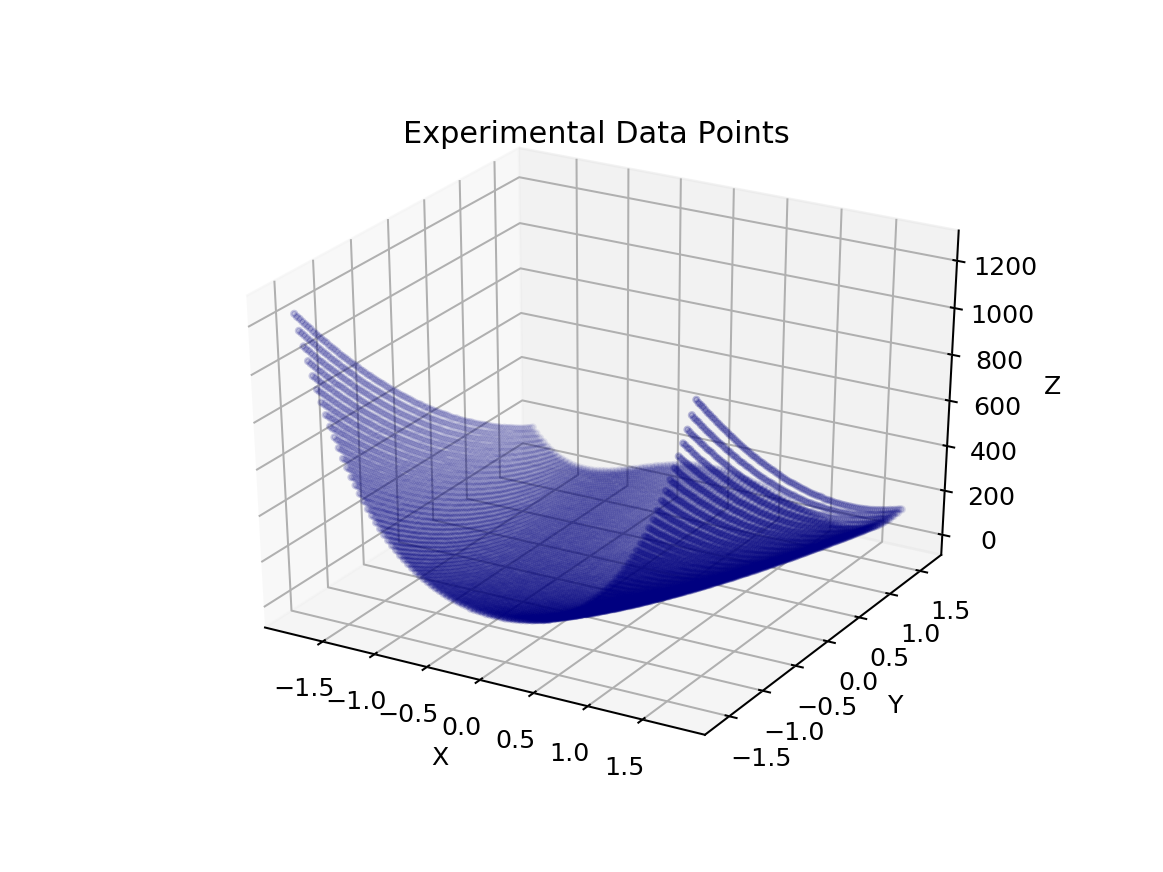

Text(0.5,0.92,'Experimental Data Points')

In [17]:
# Data set plotted

fig = plt.figure()
ax = fig.gca(projection='3d')

xs = dataset[:,0]
ys = dataset[:,1]
zs = dataset[:,2]
ax.scatter(xs, ys, zs, marker = '.', c = [(0,0,.5, .25)])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Experimental Data Points')

## 2.2.2
### We now assume the experimental data may be reproduced numerically by the function:
### $$ f: \mathbb{R} ^ 2 \rightarrow  \mathbb{R} ; \quad f(x,y) = (a-x)^2 + b(y-x^2)^2 $$
### with real-valued, unknown parameters _a_ and _b_. Find the best parameter match (a<sub>*</sub>, b<sub>*</sub>) for _f_ to represent the experimental data.
### - Define an error measure, ERR, mapping the parameter space to error values, ie:
### $$ERR: \mathbb{R} ^ 2 \rightarrow  \mathbb{R}_ {> 0}; \quad (a,b) \mapsto ERR(a,b) \in  \mathbb{R}_ {> 0}$$
### - Minimize this error using your particle swarm algorithm.
### - Visualize your error over the 2D parameter space.

In [18]:
# Define symbols
x,y,z = symbols('x y z')
a,b = symbols('a b', real = True)
i = symbols('i', cls = Idx)

# Declare function
f = (a-x)**2 + b*(y-x**2)**2

In [19]:
f

We use the _Least Squares_ method to find the error. The _Least Squares_ method is given by the minimum sum of $r_i^2$, where $r_i$ is defined by:

$$r_i = z_i - f(x_i,y_i)$$

To create a fitness function, we take the sum of all the errors squared, ie:
$$\sum_{i=0}^{n} {z_i - f(x_i,y_i,a,b)}$$
We define this function in Python:

In [20]:
def fitness_function(a,b,dataset):
    fit = 0
    for i in range(len(dataset)):
        #x value
        x = dataset[i,0]

        #y value
        y = dataset[i,1]

        #z value
        z = dataset[i,2]
        
        r = z - ((a-x)**2 + b*(y-x**2)**2)
        
        fit = r**2 + fit
        
    return fit

In [21]:
amin = -5
amax = 5
bmin = 0
bmax = 100

swarm = ParticleSwarm(fitness_function, 
                            (amin,bmin), 
                            (amax,bmax),
                             dataset=dataset )

swarm.run()

We can now see the best position, and best value of the swarm, which are attributes of the swarm

In [22]:
print(f"Swarm best value: {swarm.bestValue:.5}\nSwarm best position: ({swarm.bestPosition[0]:.5}, {swarm.bestPosition[1]:.5})")

Swarm best value: 9911.0
Swarm best position: (0.89675, 52.001)


We plot our error in $a,b$ space:

<IPython.core.display.Javascript object>


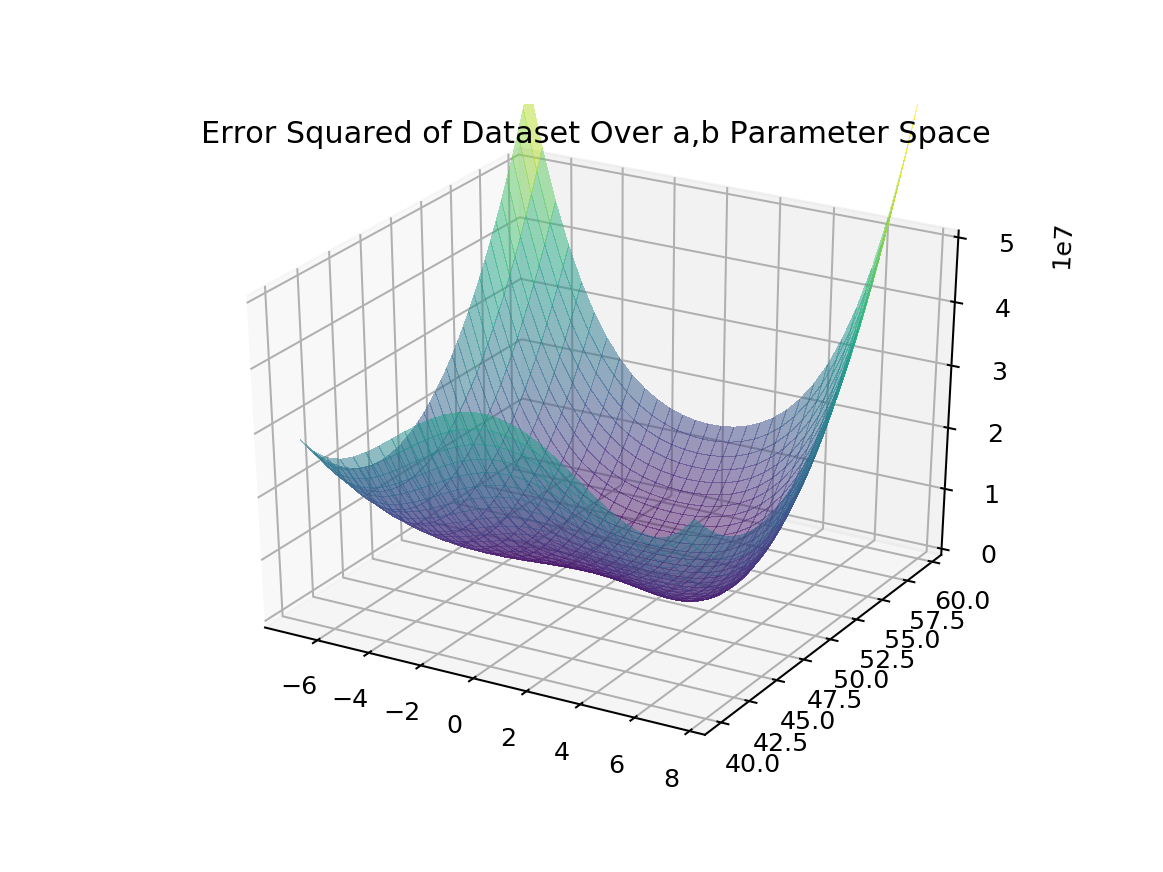

In [25]:
fig = plt.figure()
ax = fig.gca(projection='3d')

amin = -7
amax = 8
bmin = 40
bmax = 60

# Create surface from data
A = np.arange(amin, amax, .5)
B = np.arange(bmin, bmax, .5)
A, B = np.meshgrid(A, B)
Z = fitness_function(A,B,dataset)

# Plot the surface.
surf = ax.plot_surface(A, B, Z, cmap = cm.viridis,
                       linewidth=0, antialiased=False)

surf.set_alpha(.5)

# Customize the z axis.
ax.set_zlim(bottom = 0, top = 5e7)
ax.set_title('Error Squared of Dataset Over a,b Parameter Space')


plt.show()

Now that we have found the optimal values for $a$ and $b$, we plot our function of best fit.

<IPython.core.display.Javascript object>


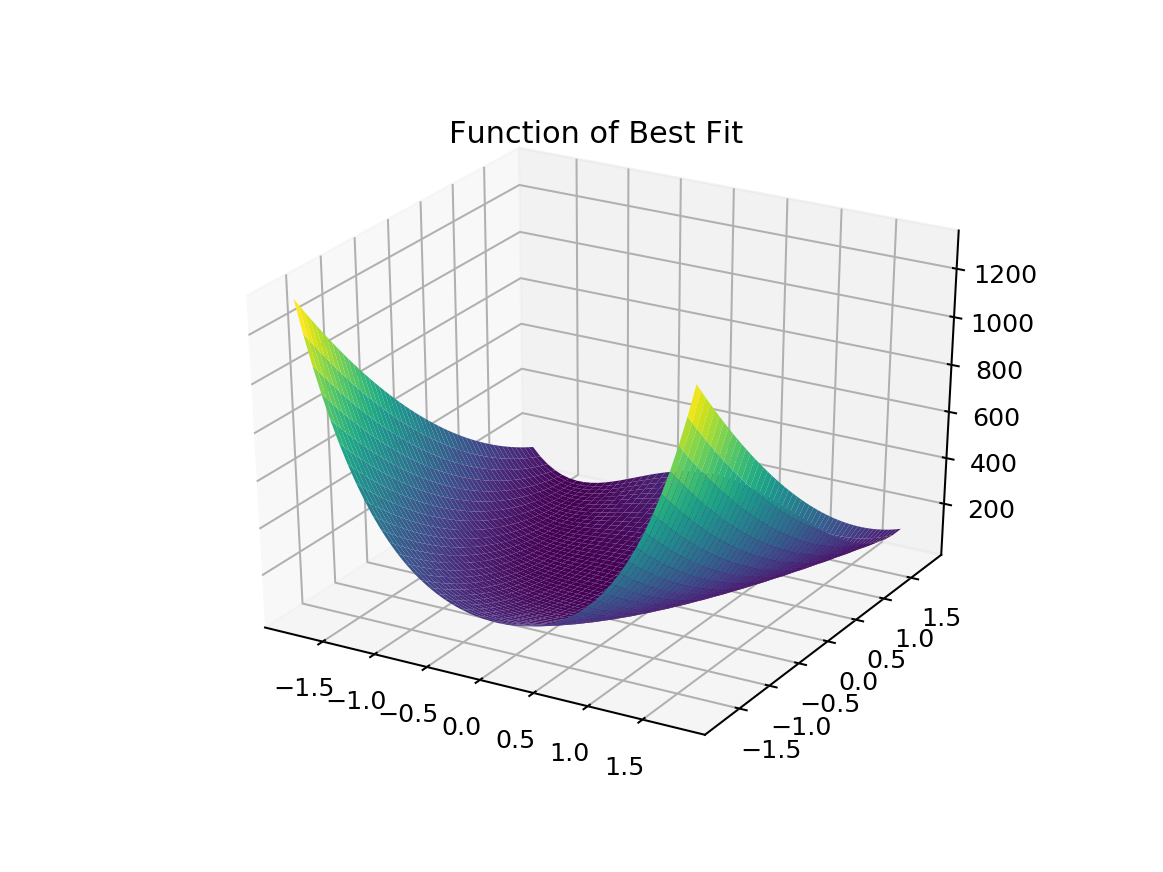

In [29]:
ymin = -1.8
ymax = 1.8
xmin = -1.8
xmax = 1.8
plot3d(f.subs([(a,swarm.bestPosition[0]),(b,swarm.bestPosition[1])]) , (x, xmin, xmax), (y, ymin, ymax),title = 'Function of Best Fit');

We then compare our function of best fit to the dataset.

<IPython.core.display.Javascript object>


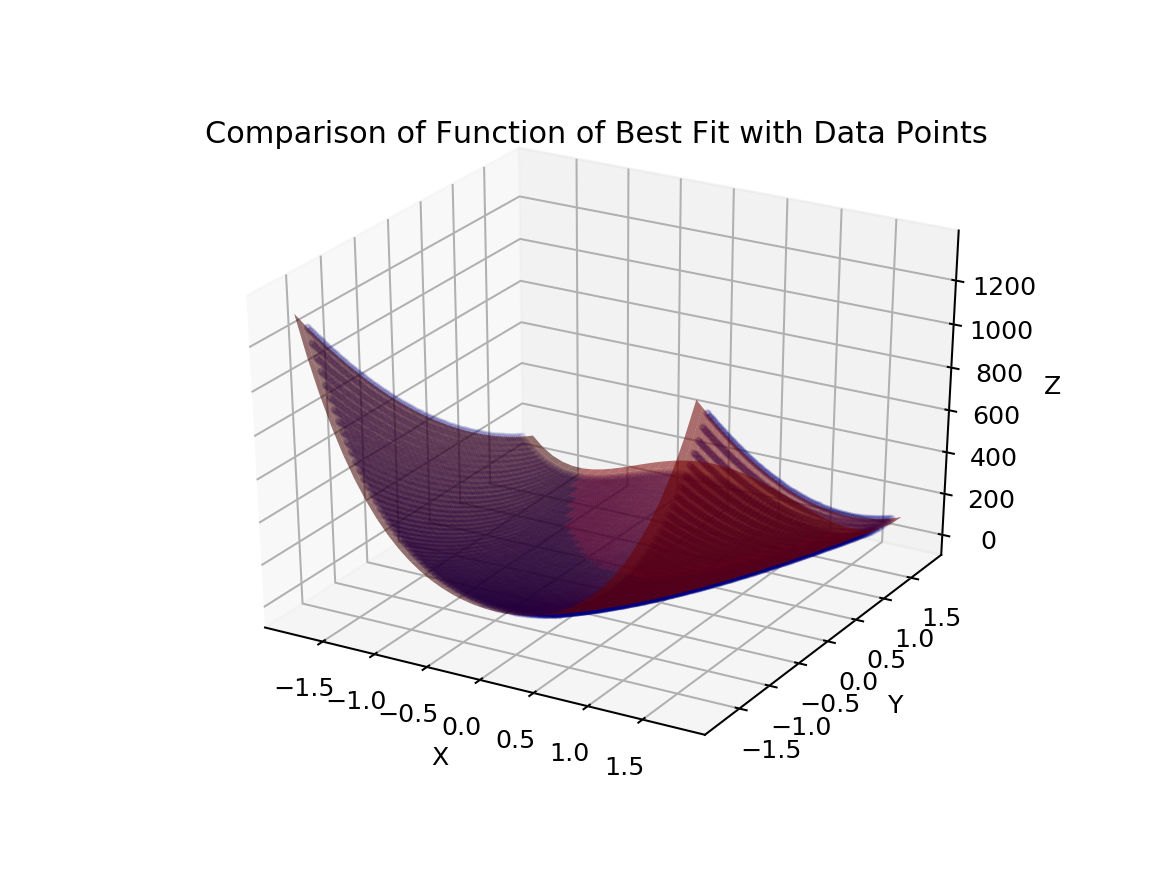

Text(0.5,0.92,'Comparison of Function of Best Fit with Data Points')

In [30]:
# Plot dataset
fig = plt.figure()
ax = fig.gca(projection='3d')

# for i in range(len(dataset)):
xs = dataset[:,0]
ys = dataset[:,1]
zs = dataset[:,2]

ax.scatter(xs, ys, zs, marker = '.', c = [(0,0,.5,.25)])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


# Plot function of best fit
ymin = -1.8
ymax = 1.8
xmin = -1.8
xmax = 1.8

X = np.arange(xmin, xmax + 0.1, .1)
Y = np.arange(ymin, ymax + 0.1, .1)
X, Y = np.meshgrid(X, Y)
Z = np.zeros(X.shape)
lambdified_func = lambdify([x,y], expr=f.subs([(a,swarm.bestPosition[0]),(b,swarm.bestPosition[1])]))                         
it = np.nditer(Z, flags=['multi_index'], op_flags=['readwrite'])

while not it.finished:
    i, j = it.multi_index
    Z[i, j] = lambdified_func(X[i, j], Y[i, j])
    it.iternext()
    
ax.plot_surface(X, Y, Z, color=(.5, 0, 0, 0.55));
ax.set_title('Comparison of Function of Best Fit with Data Points')

As seen above, the function of best fit and the dataset are very close (basically indistinguishable) in value.